#   Topic Modeling of Amazon review data

*by Johannes Bock*

In the following project I will analyze a corpus of 849 text reviews from Amazon created between June 23, 2014 and July 23, 2014. The products being reviewed are the popular wearable devices Fitbit Flex and Garmin Vivofit. The data was provided by [Julian McAuley](http://jmcauley.ucsd.edu/data/amazon/links.html) (*Inferring networks of substitutable and complementary products*, J. McAuley, R. Pandey, J. Leskovec, Knowledge Discovery and Data Mining, 2015).

The goal of this analysis is to infer meaningful topics, sentiment and subjectivity scores from the review data and visualize the data in a meaningful way.

In [1]:
import cPickle as pickle
import pandas as pd
import numpy as np

raw_review_data = pickle.load( open( "reviews_raw.pkl", "rb" ) )
num_docs = raw_review_data.shape[0]
raw_review_data["key"] = raw_review_data.index
raw_review_data.shape

(849, 14)

In [2]:
raw_review_data.head(2)

,reviewerID,asin,reviewerName,unixReviewTime,reviewText,overall,reviewTime,summary,title,price,imUrl,brand,description,key
0,A1AIRCNSF2YEHV,B00BGO0Q9O,None,1405987200,"Come off easy, Had it for less than a two week...",1.0,2014-07-22,Bad for active people,Fitbit Flex Wireless Activity + Sleep Wristban...,92.85,http://ecx.images-amazon.com/images/I/21ukcP7L...,Fitbit,,0
7,A2MOIRHND19XQK,B00BGO0Q9O,2BoysMAMA,1405123200,I bought this for my husband for Father's Day ...,5.0,2014-07-12,... for Father's Day and after a few weeks was...,Fitbit Flex Wireless Activity + Sleep Wristban...,92.85,http://ecx.images-amazon.com/images/I/21ukcP7L...,Fitbit,,7


(array([ 712.,   85.,   28.,   10.,    6.,    2.,    3.,    1.,    1.,    1.]),
 array([  1.00000000e+00,   1.36900000e+02,   2.72800000e+02,
          4.08700000e+02,   5.44600000e+02,   6.80500000e+02,
          8.16400000e+02,   9.52300000e+02,   1.08820000e+03,
          1.22410000e+03,   1.36000000e+03]),
 <a list of 10 Patch objects>)

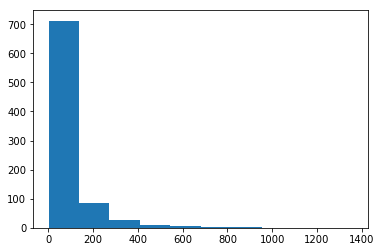

In [3]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

length=[]
for i,title in enumerate(raw_review_data["reviewText"]):
    length.append(len(title.split()))

plt.hist(length)

Each row in the dataset represents a single review and most of the reviews consist of less than 200 words.

## Text pre-processing

    1) Create bi-grams
    2) Remove punctuation and excess whitespace
    3) Lemmatize the text
    4) Remove stop-words
    5) Remove numbers
    6) Remove certain Parts-of-Speech and entities
    7) Tokenize the text

In [5]:
import spacy
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
import codecs
import itertools as it
import warnings

warnings.filterwarnings('ignore')

nlp = spacy.load('en')

### Train a bigram model

To find frequently co-occuring word pairs that carry meaning only in combination such as Los Angeles, I will train a bigram model.

In [6]:
def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    return token.is_punct or token.is_space or token == u"'"

def lemmatized_sentence_corpus(text_data):
    """
    generator function to use spaCy to parse reviews,
    lemmatize the text, and yield sentences
    """
    for parsed_text in nlp.pipe(text_data,batch_size=10000, n_threads=4):
        
        for sent in parsed_text.sents:
                yield u' '.join([token.lemma_ for token in sent
                                 if not punct_space(token)])
            
def process_text(text_data):
    with codecs.open('unigram_sentences_all.txt', 'w', encoding='utf_8') as f:
        for sentence in lemmatized_sentence_corpus(text_data):
            f.write(sentence + '\n')

In [7]:
process_text(raw_review_data["reviewText"])
unigram_sentences = LineSentence('unigram_sentences_all.txt')
bigram_model = Phrases(unigram_sentences)
bigram_model.save('bigram_model_all')

In [8]:
bigram_model = Phrases.load('bigram_model_all')

In [12]:
warnings.filterwarnings('ignore')

with codecs.open('bigram_sentences_all.txt', 'w', encoding='utf_8') as f:
        
        for unigram_sentence in unigram_sentences:
            
            bigram_sentence = u' '.join(bigram_model[unigram_sentence])
            
            f.write(bigram_sentence + '\n')
            
bigram_sentences = LineSentence('bigram_sentences_all.txt')

for bigram_sentence in it.islice(bigram_sentences, 1, 5):
    print u' '.join(bigram_sentence)
    print u''

fell off while walk_around at work and do my daily activite come right off without even notice it

the way it clip together be a horrible idea

i buy this for my_husband for father_'s day and after a_few week be amazed at everything it track and the app 's it could sync_with to track food like my fitnesspal

great buy for him



### Clean the data for modeling

Often there are words which do not carry any meaning such as stopwords and domain-specific words (e.g. Fitbit, Garmin) that are not useful for finding meaningful topics. In order to reduce the noise in the text corpus, these words are being removed.

In [13]:
import re

def is_pos_ent(token):
    return (token.ent_type_ in [unicode("PERSON"),unicode("ORG"),unicode("PRODUCT")]) or token in ["fitbit",
                                                                                                   "garmin",
                                                                                                   "fitbit_flex",
                                                                                                  "vivofit"]
def process_all_mails(df,key_idx, text_idx):
    
    num_pattern = re.compile (r"^[0-9]*$",re.UNICODE)
    clean_data = []
    
    for n,parsed_text in enumerate(nlp.pipe(df.iloc[:,text_idx],
                                  batch_size=10000, n_threads=4)):

        # lemmatize the text, removing punctuation and whitespace
        unigram_text = [token.lemma_ for token in parsed_text
                          if not punct_space(token) and not is_pos_ent(token)]

        # apply the bigram model
        bigram_text = bigram_model[unigram_text]

        # remove any remaining ENGLISH stopwords, Person names and numbers
        stopwords = spacy.en.STOPWORDS
        bigram_text = [term for term in bigram_text
                          if term not in stopwords and not num_pattern.search(term)]
        
        # write the transformed review as a line in the new file
        clean_data.append({"key":df.iloc[n,key_idx],"tokenized_text":bigram_text})
        
    df = pd.DataFrame(data=clean_data,columns = ["key","tokenized_text"])
    pickle.dump(df, open('normalized_data.pkl', 'wb')) 
    return df

In [14]:
tokenized_movie_data = process_all_mails(raw_review_data,13, 4)
tokenized_movie_data.head()

,key,tokenized_text
0,0,"[come_off, easy, less_than, two_week, lose, wa..."
1,7,"[buy, my_husband, father_'s, day, a_few, week,..."
2,20,"[love, lose, pound, fitbit, app]"
3,31,"[early, notice, accurate, use, pedometer, know..."
4,36,"[rarely, star, review, website, this_product, ..."


### Prepare the data for modeling

Since the topic modeling algorithms expect the text data to be in a specific format, we first need to transform the data and extract the input features.

In [15]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.matutils import MmReader

warnings.filterwarnings('ignore')

### Create a dictionary

In [16]:
# First build Dictionary from text data
dictionary = Dictionary(tokenized_movie_data["tokenized_text"])

# filter tokens that are very rare or too common from
# the dictionary (filter_extremes) and reassign integer ids (compactify)
dictionary.filter_extremes(no_below=int(num_docs*0.01), no_above=0.9)
dictionary.compactify()

#Save the dictionary to disk
dictionary.save("text_dict.dict")

len(dictionary)

692

### Create a Bag-of-Words Corpus

In [17]:
# create Bag-of-Words representation of the text data
def bow_generator(docs):
    """
    generator function to read mail docs
    and yield a bag-of-words representation
    """
    for doc in docs:
        yield dictionary.doc2bow(doc)

# generate bag-of-words representations for
# all mails and save them as a matrix
MmCorpus.serialize("Mail_corpus.mm",
                   bow_generator(tokenized_movie_data["tokenized_text"]))

    
# load the finished bag-of-words corpus from disk
bow_corpus = MmCorpus("Mail_corpus.mm")

In [18]:
print MmReader("Mail_corpus.mm")

MmCorpus(849 documents, 692 features, 17279 non-zero entries)


### Transform corpus

In [19]:
from gensim.matutils import corpus2csc

corpus_matrix = corpus2csc(bow_corpus).transpose().astype(int)

## Training a LDA model

Now I will train a LDA model on the text corpus. To find the appropriate number of topics for this dataset I look at the Loglikelihood first.

In [24]:
import lda
import seaborn as sns

k = range(1,30,1)
results = []
for par in k:
    lda_model = lda.LDA(n_topics=par, n_iter=1500, random_state=1)
    d=lda_model.fit(corpus_matrix)
    results.append(lda_model.loglikelihood())

INFO:lda:n_documents: 849
INFO:lda:vocab_size: 692
INFO:lda:n_words: 21501
INFO:lda:n_topics: 1
INFO:lda:n_iter: 1500
INFO:lda:<0> log likelihood: -132770
INFO:lda:<10> log likelihood: -132770
INFO:lda:<20> log likelihood: -132770
INFO:lda:<30> log likelihood: -132770
INFO:lda:<40> log likelihood: -132770
INFO:lda:<50> log likelihood: -132770
INFO:lda:<60> log likelihood: -132770
INFO:lda:<70> log likelihood: -132770
INFO:lda:<80> log likelihood: -132770
INFO:lda:<90> log likelihood: -132770
INFO:lda:<100> log likelihood: -132770
INFO:lda:<110> log likelihood: -132770
INFO:lda:<120> log likelihood: -132770
INFO:lda:<130> log likelihood: -132770
INFO:lda:<140> log likelihood: -132770
INFO:lda:<150> log likelihood: -132770
INFO:lda:<160> log likelihood: -132770
INFO:lda:<170> log likelihood: -132770
INFO:lda:<180> log likelihood: -132770
INFO:lda:<190> log likelihood: -132770
INFO:lda:<200> log likelihood: -132770
INFO:lda:<210> log likelihood: -132770
INFO:lda:<220> log likelihood: -132

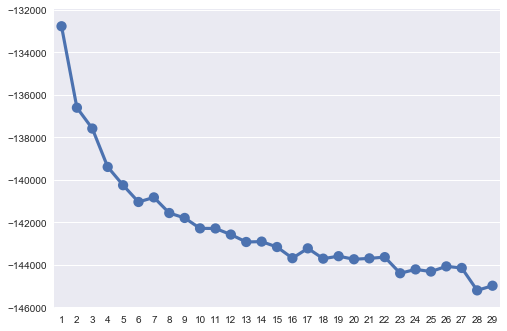

In [27]:
warnings.filterwarnings("ignore")

sns.pointplot(k,results)

It turns out a reasonable amount of topics for this dataset is **10**, since the loglikelihood starts leveling off from k=10 onwards.

In [28]:
warnings.filterwarnings("ignore")

lda_model = lda.LDA(n_topics=10, n_iter=1500, random_state=1)
lda_model.fit(corpus_matrix)

INFO:lda:n_documents: 849
INFO:lda:vocab_size: 692
INFO:lda:n_words: 21501
INFO:lda:n_topics: 10
INFO:lda:n_iter: 1500
INFO:lda:<0> log likelihood: -210950
INFO:lda:<10> log likelihood: -154265
INFO:lda:<20> log likelihood: -150236
INFO:lda:<30> log likelihood: -148195
INFO:lda:<40> log likelihood: -146800
INFO:lda:<50> log likelihood: -146145
INFO:lda:<60> log likelihood: -145538
INFO:lda:<70> log likelihood: -145054
INFO:lda:<80> log likelihood: -144338
INFO:lda:<90> log likelihood: -144177
INFO:lda:<100> log likelihood: -143729
INFO:lda:<110> log likelihood: -143882
INFO:lda:<120> log likelihood: -143764
INFO:lda:<130> log likelihood: -143357
INFO:lda:<140> log likelihood: -143284
INFO:lda:<150> log likelihood: -143337
INFO:lda:<160> log likelihood: -143351
INFO:lda:<170> log likelihood: -143158
INFO:lda:<180> log likelihood: -143133
INFO:lda:<190> log likelihood: -143318
INFO:lda:<200> log likelihood: -143216
INFO:lda:<210> log likelihood: -143134
INFO:lda:<220> log likelihood: -14

<lda.lda.LDA instance at 0x0000000015C6BA48>

In [29]:
from IPython.nbconvert.filters.markdown import markdown2html

class MD(str):
    def _repr_html_(self):
        return markdown2html(self)

In [30]:
vocab = [dictionary[i] for i in range(len(dictionary))]
topic_word = lda_model.topic_word_  
n_top_words = 20
topics = [np.array(vocab)[np.argsort(topic_dist)][:-n_top_words:-1]
          for topic_dist in topic_word]
result = ''
for i, topic_words in enumerate(topics):
    result += '* **Topic {}:** {}\n'.format(i, ' '.join(topic_words))
MD(result)

"* **Topic 0:** step track activity walk do_not sleep accurate if_you device app like run calorie count want movement mile record good\n* **Topic 1:** day love track step goal use lose calorie sleep food week exercise you_can fitbit activity great help every_day log\n* **Topic 2:** month do_not work return charge product buy fitbit customer_service replace device purchase day try contact this_product wo_not time receive\n* **Topic 3:** love fitbit ' like friend walk fact_that best better step a_lot my_husband way help_me see_how flex wish goal so_much\n* **Topic 4:** day do_not band like time sleep display fitbit sync use force light know feature great site alarm different wish\n* **Topic 5:** use love great sleep easy as_well fitbit try tool month daily app this_product track work feature easily want recommend\n* **Topic 6:** data use you_can buy do_not device come vivofit if_you product monitor provide heart_rate garmin information app feature thing fitness\n* **Topic 7:** ' wear like time use work tracker flex sync easy shower want do_not a_little think need website water thing\n* **Topic 8:** band fall_off device lose wrist clasp wear think way read do_not purchase watch design stay notice strap small need\n* **Topic 9:** charge fitbit love time good ' battery work wristband day step do_not charger issue hold idea fine unit year\n"

In [31]:
topics = ["activity-tracking running calories",
          "goal lose calorie food exercise",
          "return customer_service replace",
          "love like best help_me",
          "features other",
          "love recommend great",
          "data use monitor information",
          "wear work shower water",
          "band fall_off wrist",
          "charging battery"]

Above, I summarize the 10 topics identified by the LDA model.

## Topic-Document Distribution and Similarity

For visualisation purposes I transformed the topic-document distribution into a "similarity distribution".

In [32]:
doc_topic = pd.DataFrame(lda_model.doc_topic_)
top_topic = doc_topic.transpose().idxmax()

In [33]:
def get_topic(topic_number):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
    return topics[topic_number]

In [34]:
movie_topic = []
for n,doc_num in enumerate(top_topic):
    topic_terms = get_topic(doc_num)
    movie_topic.append({"key":tokenized_movie_data.iloc[n,0],"topic_terms":topic_terms})
movie_data_topics = pd.DataFrame.from_dict(movie_topic)

### Doc-Topic correlation

Having tried different similarity metrics and different thresholds, I decided to use the cosine-similarity to compute the correlation between topics and documents.

In [35]:
from sklearn.metrics.pairwise import cosine_similarity

doc_similarity = pd.DataFrame(cosine_similarity(doc_topic))
doc_correlations = doc_topic.transpose().corr()

doc_correlations[doc_correlations < .8] = 0
np.fill_diagonal(doc_correlations.values, 0)

doc_similarity[doc_similarity < .85] = 0
np.fill_diagonal(doc_similarity.values, 0)

## Sentiment & subjectivity scores

In order to augment the text data and get further metrics for later analysis, I also computed the text sentiment and subjectivity scores.

In [37]:
from textblob import TextBlob

df = raw_review_data.merge(movie_data_topics,how='left',on = "key",copy=False)
df["url"] = "www.amazon.com/gp/profile/"+df["reviewerID"]

sent_data = []
for i,row in df.iterrows():
    parsed = TextBlob(row["reviewText"])
    sentiment = parsed.sentiment.polarity
    subjectivity = parsed.sentiment.subjectivity
    sent_data.append({"key":row["key"],"sentiment":sentiment,"subjectivity":subjectivity})
    
sent_data=pd.DataFrame.from_dict(sent_data)
df = df.merge(sent_data,how='left',on = "key",copy=False)
df["review_length"] = length
df["reviewTime"]=df["reviewTime"].astype(str)
df.fillna(value="Not available", inplace=True)
df.to_csv("review_data.csv")

df.head(2)

,reviewerID,asin,reviewerName,unixReviewTime,reviewText,overall,reviewTime,summary,title,price,imUrl,brand,description,key,topic_terms,url,sentiment,subjectivity,review_length
0,A1AIRCNSF2YEHV,B00BGO0Q9O,Not available,1405987200,"Come off easy, Had it for less than a two week...",1.0,2014-07-22,Bad for active people,Fitbit Flex Wireless Activity + Sleep Wristban...,92.85,http://ecx.images-amazon.com/images/I/21ukcP7L...,Fitbit,,0,band fall_off wrist,www.amazon.com/gp/profile/A1AIRCNSF2YEHV,-0.089524,0.487143,43
1,A2MOIRHND19XQK,B00BGO0Q9O,2BoysMAMA,1405123200,I bought this for my husband for Father's Day ...,5.0,2014-07-12,... for Father's Day and after a few weeks was...,Fitbit Flex Wireless Activity + Sleep Wristban...,92.85,http://ecx.images-amazon.com/images/I/21ukcP7L...,Fitbit,,7,goal lose calorie food exercise,www.amazon.com/gp/profile/A2MOIRHND19XQK,0.400000,0.425000,37


The dataset above is the final version which will be used to create appealing visualizations using d3.js

## Prepare data for network visualisation

In [38]:
import networkx as nx
import random
titles = df['key']
doc_graph = nx.Graph(doc_similarity.values)
doc_graph = nx.relabel_nodes(doc_graph, titles)

for _,row in df.iterrows():
    doc_graph.node[row["key"]]={"topic":row["topic_terms"],"date":row["reviewTime"],"author":row["reviewerName"],
                                "brand":row["brand"],"stars":row["overall"],
                               "Label":row["summary"],"source":row["url"],"length":row["review_length"]}
    
nx.write_graphml(doc_graph, 'docs.graphml')